# Middle Term Test 2 - COVID-19 Fake News Detection

## Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Cargar Dataset

In [46]:
# Cargar los datasets
train_df = pd.read_excel('data/Constraint_English_Train.xlsx')
val_df = pd.read_excel('data/Constraint_English_Val.xlsx')
test_df = pd.read_excel('data/Constraint_English_Test.xlsx')
# Cargar los labels reales del test
test_labels_df = pd.read_excel('data/english_test_with_labels.xlsx')  # Ajusta el nombre si es necesario
y_test = test_labels_df['label']

# Mostrar información básica
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("\nPrimeras filas del dataset de entrenamiento:")
train_df.head()

Train shape: (6420, 3)
Validation shape: (2140, 3)
Test shape: (2140, 2)

Primeras filas del dataset de entrenamiento:


,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


Primero, estudiamos los datos del dataset

In [47]:
print(train_df.isnull().sum())
# Eliminar URLs de los tweets en los datasets
import re
def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+', '', str(text))
train_df['tweet'] = train_df['tweet'].apply(remove_urls)
val_df['tweet'] = val_df['tweet'].apply(remove_urls)
test_df['tweet'] = test_df['tweet'].apply(remove_urls)

id       0
tweet    0
label    0
dtype: int64


## Análisis de la distribución de clases
Vamos a visualizar cuántas noticias reales y falsas hay en el dataset de entrenamiento.

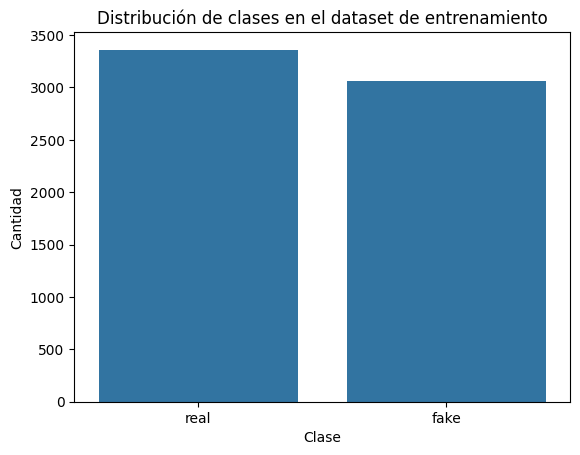

In [48]:
# Visualizar la distribución de clases en el dataset de entrenamiento
sns.countplot(x='label', data=train_df)
plt.title('Distribución de clases en el dataset de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

##  Tokenización de las palabras
Ahora vamos a empezar a tokenizar las palabras del dataset

In [49]:
# Definir la lista de stopwords en inglés
stop_words = set(stopwords.words("english"))

# Tokenizar y filtrar cada tweet
train_df['tokens'] = train_df['tweet'].apply(lambda x: [w for w in word_tokenize(str(x)) if w.lower() not in stop_words and w.isalpha()])

# Mostrar los primeros ejemplos tokenizados
train_df[['tweet', 'tokens']]

,tweet,tokens
0,The CDC currently reports 99031 deaths. In gen...,"[CDC, currently, reports, deaths, general, dis..."
1,States reported 1121 deaths a small rise from ...,"[States, reported, deaths, small, rise, last, ..."
2,Politically Correct Woman (Almost) Uses Pandem...,"[Politically, Correct, Woman, Almost, Uses, Pa..."
3,#IndiaFightsCorona: We have 1524 #COVID testin...,"[IndiaFightsCorona, COVID, testing, laboratori..."
4,Populous states can generate large case counts...,"[Populous, states, generate, large, case, coun..."
...,...,...
6415,A tiger tested positive for COVID-19 please st...,"[tiger, tested, positive, please, stay, away, ..."
6416,???Autopsies prove that COVID-19 is??� a blood...,"[Autopsies, prove, blood, clot, pneumonia, oug..."
6417,_A post claims a COVID-19 vaccine has already ...,"[post, claims, vaccine, already, developed, ca..."
6418,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,"[Aamir, Khan, Donate, Cr, PM, Relief, Cares, F..."


## Relación entre tokens y la veracidad
Vamos a analizar si existen tokens (palabras) que aparecen con mayor frecuencia en noticias verdaderas o falsas.

In [50]:
from collections import Counter
import itertools
 
# Separar los tweets verdaderos y falsos
true_tokens = list(itertools.chain.from_iterable(train_df[train_df['label']=='real']['tokens']))
fake_tokens = list(itertools.chain.from_iterable(train_df[train_df['label']=='fake']['tokens']))
 
# Contar las palabras más frecuentes en cada grupo
true_freq = Counter(true_tokens).most_common(20)
fake_freq = Counter(fake_tokens).most_common(20)
 
print('Palabras más frecuentes en noticias VERDADERAS:')
print(true_freq)
print('\nPalabras más frecuentes en noticias FALSAS:')
print(fake_freq)

Palabras más frecuentes en noticias VERDADERAS:
[('cases', 1485), ('tests', 605), ('new', 603), ('number', 489), ('deaths', 445), ('reported', 443), ('people', 439), ('confirmed', 431), ('amp', 424), ('total', 411), ('testing', 361), ('IndiaFightsCorona', 317), ('India', 284), ('today', 280), ('states', 279), ('report', 277), ('New', 255), ('COVID', 246), ('coronavirus', 245), ('RT', 245)]

Palabras más frecuentes en noticias FALSAS:
[('coronavirus', 1043), ('people', 260), ('Trump', 248), ('Coronavirus', 231), ('pandemic', 209), ('India', 203), ('virus', 183), ('vaccine', 170), ('video', 155), ('President', 142), ('cases', 139), ('new', 135), ('said', 129), ('shows', 129), ('claims', 122), ('lockdown', 119), ('patients', 113), ('died', 110), ('hospital', 105), ('positive', 101)]


## Tokens con mayor proporción de verdad
Ahora vamos a calcular, para cada token, el porcentaje de veces que aparece en noticias verdaderas respecto al total de apariciones.

In [51]:
# Calcular el porcentaje de verdad para cada token
all_tokens = list(itertools.chain.from_iterable(train_df['tokens']))
all_freq = Counter(all_tokens)
true_freq = Counter(true_tokens)
 
# Crear un DataFrame con el porcentaje de verdad
token_stats = pd.DataFrame({
    'token': list(all_freq.keys()),
    'total': [all_freq[t] for t in all_freq],
    'verdaderas': [true_freq[t] for t in all_freq],
})
token_stats['porcentaje_verdad'] = token_stats['verdaderas'] / token_stats['total']
 
# Mostrar los tokens con mayor porcentaje de verdad (mínimo 10 apariciones para evitar sesgos)
tokens_filtrados = token_stats[token_stats['total'] >= 10]
top_tokens = tokens_filtrados.sort_values('porcentaje_verdad', ascending=False).head(20)
print(top_tokens[['token', 'total', 'verdaderas', 'porcentaje_verdad']])

              token  total  verdaderas  porcentaje_verdad
1576         Follow     22          22                1.0
1689            MIQ     29          29                1.0
1687     considered     26          26                1.0
39     laboratories     69          69                1.0
1530  airnewsalerts     30          30                1.0
1514            ora     13          13                1.0
1513            Kia     14          14                1.0
1531     mygovindia     21          21                1.0
1745        pending     18          18                1.0
1463     strategies     10          10                1.0
1477    Fmohnigeria     10          10                1.0
1713      processed     41          41                1.0
5866          Level     24          24                1.0
5838          refer     10          10                1.0
1488        Waikato     15          15                1.0
1478           Kano     12          12                1.0
1370    Accele

## Entrenamiento usando tokens con 100% de probabilidad de verdad
Entrenaremos el modelo usando solo las palabras que aparecen exclusivamente en noticias verdaderas.

In [52]:
# Seleccionar tokens con 80% de probabilidad de verdad y al menos 10 apariciones
tokens_100 = tokens_filtrados[tokens_filtrados['porcentaje_verdad'] >= 0.8]['token'].tolist()
 
# Vectorizar solo usando esos tokens
vectorizer_100 = CountVectorizer(vocabulary=tokens_100)
X_train_100 = vectorizer_100.transform(train_df['tweet'])
y_train = train_df['label']
 
# Entrenar el modelo
model_100 = LogisticRegression()
model_100.fit(X_train_100, y_train)
 
print(f"Número de tokens usados: {len(tokens_100)}")

Número de tokens usados: 511


Accuracy: 0.8570093457943925

Classification report:
              precision    recall  f1-score   support

        fake       0.81      0.91      0.86      1020
        real       0.91      0.81      0.85      1120

    accuracy                           0.86      2140
   macro avg       0.86      0.86      0.86      2140
weighted avg       0.86      0.86      0.86      2140



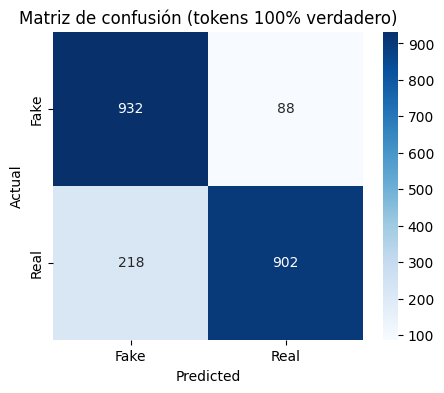

In [53]:
# Evaluar el modelo en el conjunto de validación
X_val_100 = vectorizer_100.transform(val_df['tweet'])
y_val = val_df['label']
 
y_pred = model_100.predict(X_val_100)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification report:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión (tokens 100% verdadero)')
plt.show()

## Entrenamiento usando tokens con 100% de probabilidad de falso
Entrenaremos el modelo usando solo las palabras que aparecen exclusivamente en noticias falsas.

Accuracy: 0.7813084112149533

Classification report:
              precision    recall  f1-score   support

        fake       0.80      0.73      0.76      1020
        real       0.77      0.83      0.80      1120

    accuracy                           0.78      2140
   macro avg       0.78      0.78      0.78      2140
weighted avg       0.78      0.78      0.78      2140



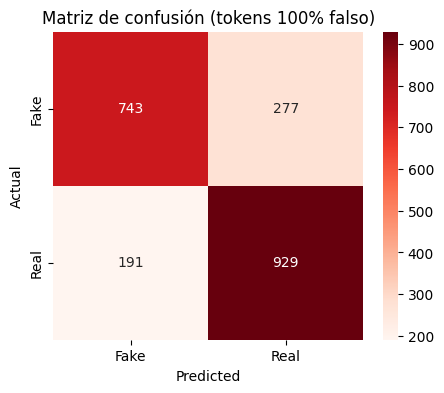

In [54]:
# Seleccionar tokens con 100% de probabilidad de falso y al menos 10 apariciones
tokens_0 = tokens_filtrados[tokens_filtrados['porcentaje_verdad'] <= 0.2]['token'].tolist()
 
# Vectorizar solo usando esos tokens
vectorizer_0 = CountVectorizer(vocabulary=tokens_0)
X_train_0 = vectorizer_0.transform(train_df['tweet'])
 
# Entrenar el modelo
model_0 = LogisticRegression()
model_0.fit(X_train_0, y_train)
 
# Evaluar el modelo en el conjunto de validación
X_val_0 = vectorizer_0.transform(val_df['tweet'])
y_pred_0 = model_0.predict(X_val_0)
print("Accuracy:", accuracy_score(y_val, y_pred_0))
print("\nClassification report:")
print(classification_report(y_val, y_pred_0))
cm_0 = confusion_matrix(y_val, y_pred_0)
plt.figure(figsize=(5,4))
sns.heatmap(cm_0, annot=True, fmt='d', cmap='Reds', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión (tokens 100% falso)')
plt.show()

## Entrenamiento usando tokens exclusivos de verdad y falso
Entrenaremos el modelo usando la combinación de tokens exclusivos de noticias verdaderas y falsas.

Accuracy: 0.8789719626168224

Classification report:
              precision    recall  f1-score   support

        fake       0.85      0.90      0.88      1020
        real       0.91      0.86      0.88      1120

    accuracy                           0.88      2140
   macro avg       0.88      0.88      0.88      2140
weighted avg       0.88      0.88      0.88      2140



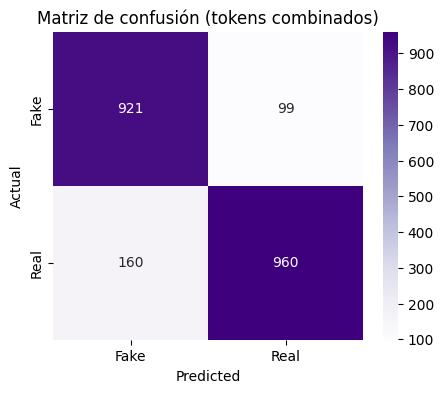

In [55]:
# Unir tokens exclusivos de verdad y falso
tokens_combined = list(set(tokens_100 + tokens_0))
vectorizer_combined = CountVectorizer(vocabulary=tokens_combined)
X_train_combined = vectorizer_combined.transform(train_df['tweet'])
 
# Entrenar el modelo combinado
model_combined = LogisticRegression()
model_combined.fit(X_train_combined, y_train)
 
# Evaluar el modelo en el conjunto de validación
X_val_combined = vectorizer_combined.transform(val_df['tweet'])
y_pred_combined = model_combined.predict(X_val_combined)
print("Accuracy:", accuracy_score(y_val, y_pred_combined))
print("\nClassification report:")
print(classification_report(y_val, y_pred_combined))
cm_combined = confusion_matrix(y_val, y_pred_combined)
plt.figure(figsize=(5,4))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Purples', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión (tokens combinados)')
plt.show()

## Comparación de resultados de los modelos
A continuación se comparan las métricas de los tres modelos: solo tokens 100% verdad, solo tokens 100% falso y tokens combinados.

Accuracy tokens 100% verdad: 0.8570093457943925
Accuracy tokens 100% falso: 0.7813084112149533
Accuracy tokens combinados: 0.8789719626168224


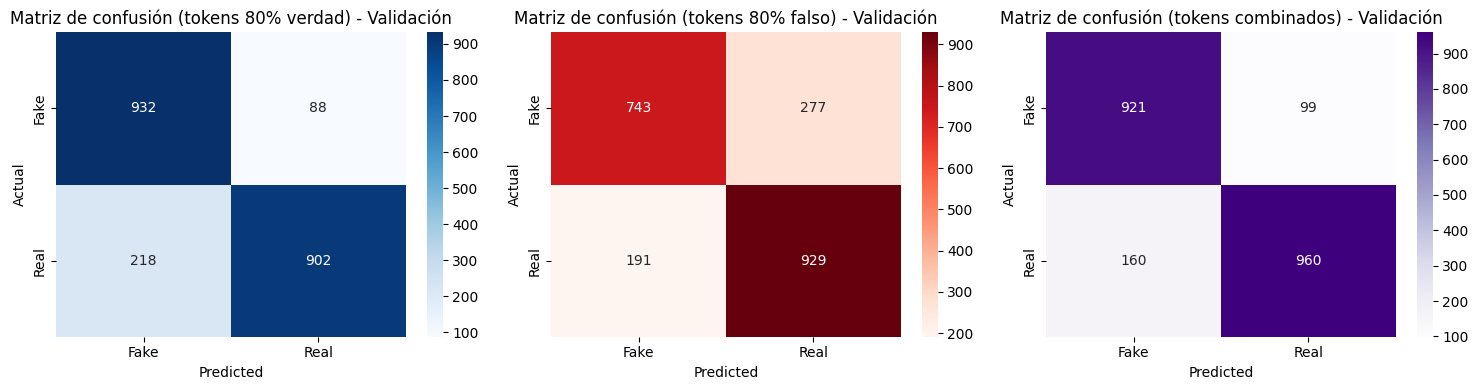

In [56]:
# Comparar accuracy de los tres modelos
acc_100 = accuracy_score(y_val, y_pred)
acc_0 = accuracy_score(y_val, y_pred_0)
acc_combined = accuracy_score(y_val, y_pred_combined)
 
print("Accuracy tokens 100% verdad:", acc_100)
print("Accuracy tokens 100% falso:", acc_0)
print("Accuracy tokens combinados:", acc_combined)
 
# Visualizar las matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cm_val_100 = confusion_matrix(y_val, y_pred)
cm_val_0 = confusion_matrix(y_val, y_pred_0)
cm_val_combined = confusion_matrix(y_val, y_pred_combined)

sns.heatmap(cm_val_100, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Matriz de confusión (tokens 80% verdad) - Validación')

sns.heatmap(cm_val_0, annot=True, fmt='d', cmap='Reds', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Matriz de confusión (tokens 80% falso) - Validación')

sns.heatmap(cm_val_combined, annot=True, fmt='d', cmap='Purples', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'], ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Matriz de confusión (tokens combinados) - Validación')

plt.tight_layout()
plt.show()

## Evaluación de los modelos con el conjunto de test
Ahora vamos a evaluar los tres modelos usando el conjunto de test y comparar los resultados con los labels reales.

Accuracy modelo 80% verdad (test): 0.8411214953271028
Accuracy modelo 80% falso (test): 0.7962616822429907
Accuracy modelo combinado (test): 0.8794392523364486

Classification report modelo 80% verdad (test):
              precision    recall  f1-score   support

        fake       0.79      0.90      0.84      1020
        real       0.90      0.79      0.84      1120

    accuracy                           0.84      2140
   macro avg       0.85      0.84      0.84      2140
weighted avg       0.85      0.84      0.84      2140


Classification report modelo 80% falso (test):
              precision    recall  f1-score   support

        fake       0.81      0.75      0.78      1020
        real       0.79      0.84      0.81      1120

    accuracy                           0.80      2140
   macro avg       0.80      0.79      0.79      2140
weighted avg       0.80      0.80      0.80      2140


Classification report modelo combinado (test):
              precision    recall  f1-sco

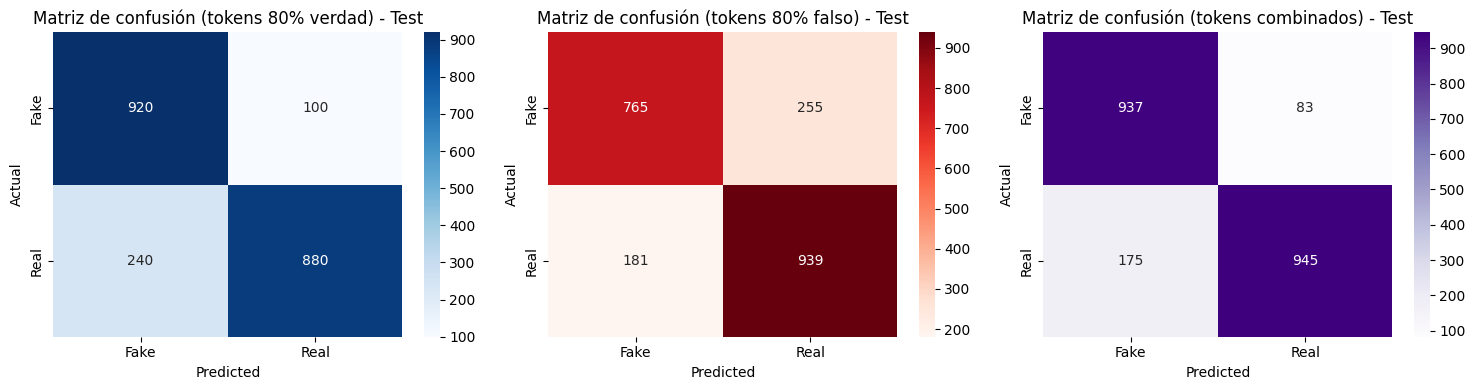

In [57]:
# Evaluar los modelos en el conjunto de test
X_test_100 = vectorizer_100.transform(test_df['tweet'])
X_test_0 = vectorizer_0.transform(test_df['tweet'])
X_test_combined = vectorizer_combined.transform(test_df['tweet'])
y_test = test_labels_df['label']  # testwithlabels
 
y_pred_test_100 = model_100.predict(X_test_100)
y_pred_test_0 = model_0.predict(X_test_0)
y_pred_test_combined = model_combined.predict(X_test_combined)
 
print("Accuracy modelo 80% verdad (test):", accuracy_score(y_test, y_pred_test_100))
print("Accuracy modelo 80% falso (test):", accuracy_score(y_test, y_pred_test_0))
print("Accuracy modelo combinado (test):", accuracy_score(y_test, y_pred_test_combined))
 
print("\nClassification report modelo 80% verdad (test):")
print(classification_report(y_test, y_pred_test_100))

print("\nClassification report modelo 80% falso (test):")
print(classification_report(y_test, y_pred_test_0))

print("\nClassification report modelo combinado (test):")
print(classification_report(y_test, y_pred_test_combined))

# Matrices de confusión para el conjunto de test
cm_test_100 = confusion_matrix(y_test, y_pred_test_100)
cm_test_0 = confusion_matrix(y_test, y_pred_test_0)
cm_test_combined = confusion_matrix(y_test, y_pred_test_combined)

# Visualizar las matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap(cm_test_100, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Matriz de confusión (tokens 80% verdad) - Test')

sns.heatmap(cm_test_0, annot=True, fmt='d', cmap='Reds', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Matriz de confusión (tokens 80% falso) - Test')

sns.heatmap(cm_test_combined, annot=True, fmt='d', cmap='Purples', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'], ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Matriz de confusión (tokens combinados) - Test')

plt.tight_layout()
plt.show()